# Cavity-QED in the dispersive regime with eHe

Author: K. V. Shulga (kirill-shulga@oist.jp)

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from qutip import *
import pickle
import scipy.sparse as sp

import importlib
import Lib
importlib.reload(Lib)
from Lib import getXops, getEigMel, getEb0, _izj2, find_nearest 
from Lib import getHamiltonian_z, Hamiltonian_z_solve, getHamiltonian_full, Hamiltonian_full_solve 
from Lib import getHamiltonian, Hamiltonian_solve

from scipy.sparse.linalg import eigsh

# Introduction

Free electrons can be trapped near the surface of liquid helium (at a distance of about 10 nm) due to a weak attraction to the liquid (polarizability of helium atoms) and a repulsion from the helium atoms (Pauli exclusion principle). The basic quantum-mechanical Hamiltonian for a single electron above liquid helium is given by

### $H = \frac{\textbf{P}^2}{2m_e} + V(\textbf{R})$,

where $m_e$ is the bare electron mass. Assuming an infinitely extended flat surface of liquid, the potential energy of an electron can be written as

### $V(\textbf{R}) = V_0 \Theta(-z) - \frac{\Lambda}{z}\Theta(z)$.

Here $z$ is the electron coordinate in the direction perpendicular to the surface, $V_0 \approx 1$ eV is the height of the repulsive potential barrier at $z=0$, and $\Theta(z)$ is the Heaviside (step) function.

### Problem parameters

Physical constants definition (in SI units)

In [3]:
from scipy.constants import e, h, hbar, k, m_e, epsilon_0, mu_0

In [4]:
hb   = hbar                            # Plank constant [Js], or 4.136e-15 [eV s]
qe   = e                               # elementary charge [C]
ep4  = 1.0572                          # the relative permittivity of 4He
ep32 = 1.0462                          # the relative permittivity of 3He
ep3  = 1.042                           # the relative permittivity of 3He (in Monakha's book)
ep0  = epsilon_0                       # the electric constant (vacuum permittivity) [C^2 Nm^-2]
mu0  = mu_0                            # the magnetic constant [Tm/A]
me   = m_e                             # electron mass [kg] or 0.5109 [MeV]
mb   = 9.2740100783e-24                # Bohr Magneton [J T^-1]

The term $\frac{\Lambda}{z}\Theta(z)$ describes attraction of an electron to a weak image charge inside the liquid, where $\Lambda$ is determined by the dielectric constant of liquid helium ε as

### $\Lambda = \frac{e^2}{16\pi\varepsilon_0}\frac{\varepsilon -1}{\varepsilon+1}$.

In [5]:
l4  = qe**2 / 4 * ( ep4 - 1) / ( ep4 + 1) / 4 / ep0 / np.pi     # the Coulomb constant for 4He
#l3  = qe**2 / 4 * ( ep3 - 1) / ( ep3 + 1) / 4 / ep0 / np.pi     # the Coulomb constant for 3He (Monakha's book)
#l32 = qe**2 / 4 * (ep32 - 1) / (ep32 + 1) / 4 / ep0 / np.pi     # the Coulomb constant for 3He

Define the energy and length scale we choose for $^3$He:

In [6]:
#The whole system uses energy scale of Rydberg_Constant, and length scale of Borh_Radius
    
Rydberg_Constant = me * l4**2/(2 * hb**2)                         # the Rydberg constant for image charge in 4He
Borh_Radius = hb**2/(l4 * me)                                     # the effective Borh radius

The main Hamiltonian can be separated into two parts corresponding to the orbital motion of an electron in the direction perpendicular to the surface ($H_z$) and parallel to the surface. In z-direction, the electron motion is quantized into the surface bound states which are the eigenstates of the Hamiltonian

### $H_z = \frac{p_z^2}{2m_e} + V_0 \Theta(-z) - \frac{\Lambda}{z}\Theta(z) $.

The energy spectrum of this motion can be easily found by making an assumption of a rigid-wall repulsive barrier, that is $V_0 \rightarrow +\infty$. In this case it coincides with the energy spectrum of an electron in the hydrogen atom $−R_e/n^2,~~ n=1,2,..$, where $R_e = m_e\Lambda^2/(2 ̄\hbar^2)$ is the effective Rydberg constant. This constant is about 63 meV (36 meV) for an electron above liquid $^4$He ($^3$He). An electron in the ground Rydberg state localizes above the surface of liquid at an average distance $〈z〉 \approx r_B$, where $r_B = \hbar^2/(\Lambda m_e)$ is the effective Bohr radius. This radius is about 7.8 nm (10.3 nm) for an electron above liquid $^4$He ($^3$He).

In [7]:
# introduce coordinate operators z and 1/z as well as Laplacian in z basis
zgrid, z, zgrid_rev, z_rev, Lapz = getXops(7000, zmin = -1e-2, zmax = 300, odr = 1)  #2500 points is OK

There is always a static electric field $E_⊥$ applied perpendicular to the liquid surface.  The dc-Stark shift induced by this field provides a way to tune energy difference between the Rydberg states for their spectroscopic studies. It adds an additional term $eE_⊥z$ to the Hamiltonian and changes its eigenenergy spectrum.

In [8]:
Electric_field  = 3.5*5*100                                              # perpendicular Electric field [V/cm*100]
dcStark_shift = Electric_field  * (qe*Borh_Radius/Rydberg_Constant)       # additional dc-Stark term     

We also introduce a horizontal component of the tilted magnetic field. 
The new (diamagnetic) term appears in this Hamiltonian because of the presence of a parallel component of the magnetic field.

### $H_q = \frac{m_e\omega_y^2z^2}{2}$,

where we define $\omega_y=eB_y/m_e$. 

In [9]:
B_y   = 0.03                                                             # horizontal magnetic field B_y [T]
Omega_y  = B_y * (qe/me)                                                 # \Omega_y value

Then we construct the Hamiltonian $𝐻_𝑧$ and solve it by finding its eigenvalues

In [10]:
Hz_c =  2.0 *sp.diags(zgrid_rev, offsets = 0, dtype = np.double)   # the coulomb interaction term. 
                                                                   # 2.0=l3/Rydberg_Constant/Borh_Radius     
Hz_p = -1 * Lapz                                                   # the momentum term
Hz_e =  dcStark_shift * z                                          # the linear potential term 
Hz_q =  0.5 * (Omega_y*hb/Rydberg_Constant)**2 * z*z               # the quadratic diamagnetic term
    
Vz = Hz_c + Hz_e + Hz_q
Hz = Hz_p + Vz

In [11]:
eigenvalues_z, eigenvectors_z = eigsh(Hz, which='SA', k = 20, tol = 0.0001)  
i_z_j = getEigMel(z,eigenvectors_z)
print('Rydberg frequency:', (eigenvalues_z[1]-eigenvalues_z[0]) * (Rydberg_Constant/h/1e9), 'GHz')
print('Anharmonicity:', (eigenvalues_z[2]-eigenvalues_z[1]-((eigenvalues_z[1]-eigenvalues_z[0]))) * (Rydberg_Constant/h/1e9), 'GHz')

Rydberg frequency: 138.09015596640285 GHz
Anharmonicity: -98.71099969338289 GHz


In [12]:
for i in range(10):
    print((eigenvalues_z[i+1]-eigenvalues_z[i]) * (Rydberg_Constant/h/1e9))

138.09015596640285
39.37915627301994
24.62268217312799
19.4002930928996
16.701580301874536
15.01639545759994
13.842666030533742
12.965969358480706
12.278839201956117
11.72111823385471


When an electron are subject to a static magnetic field $B_z$ applied perpendicular to the surface, the electron in-plane motion is quantized into the states with an equidistant energy spectrum $\hbar\omega_c (l+1/2)$ (the Landau levels), where $\omega_c=eB_z/m_e$ is the cyclotron frequency and $l=0,1,..$ is the quantum number. 

In [13]:
#B_z = np.linspace(0, 3.5, 350)                                  # vertical magnetic field B_z field [T]
#B_z = 0.03572386754*6
B_z = 0.2085
Omega_c = (qe/me) * B_z                                          # cyclotron frequencies 

print('Landau frequency:', Omega_c/(2*np.pi)/10**9, 'GHz')

Landau frequency: 5.836434138381438 GHz


The verticaland in-plane motions of an electron are uncoupled, and the full Hamiltonian describing the electron’s orbital motion can be represented as

### $H_0 = H_z + \frac{(\textbf{p}+e\textbf{A})^2}{2m_e} = H_z + \hbar\omega_c(a^{\dagger} a+\frac{1}{2})$,

where $\textbf{A}$ is the vector potential. We define the operator $a = (\sqrt{2}l_B)^{−1}(p_xl^2_B/\hbar-i(x+x_0))$, where $x_0=p_y/(eB_z)$ and $ l_B=\sqrt{\hbar/eB_z}$.  The operator $a$ satisfies the commutation relation $[a,a^{\dagger}] = 1$.


Each electron eigenstate is the product of a Rydberg state $|n〉$ of vertical motion corresponding to the eigenenergy $E_n$ of the Hamiltonian $H_z$ and a state $|l〉$ of in-plane cyclotron motion, where $a^{\dagger}a|l〉=l|l〉$. 

When an additional component of static magnetic field is applied parallel to the liquid surface, in other words when the magnetic field $B$ is tilted with respect to z-axis, the vertical and in-plane motions are coupled. The electron full Hamiltonian becomes

### $H = (H_z + \frac{m_e\omega_y^2z^2}{2}) + \hbar\omega_c(a^{\dagger} a+\frac{1}{2}) + \frac{\hbar \omega_y}{\sqrt{2}l_B}(a^{\dagger}+a)z$ .


Now, let's construct the Full Hamiltonian with the interaction term. 
Each electron eigenstate is the product of a Rydberg state $|n〉$ of vertical motion corresponding to the eigenenergy $E_n$ of the Hamiltonian $H_z$ and a state $|l〉$ of in-plane cyclotron motion, where $a^{\dagger}a|l〉=l|l〉$. 

In [14]:
# Dimension of the annihilation and creation operator space
dimension = 15                                  
# annihilation and creation operators
a  = sp.diags(np.sqrt(np.arange(dimension - 1) + 1), 1, dtype = np.double)
ad = a.transpose()
# Patricle number operator
N = ad.dot(a)
# Interaction operator
Int = a + ad                                                #position z operator

Next construct the full Hamiltonian for the electron over the helium surface 
in an tilted magnetic field as well as in the presence of a controlling electric field.

In [15]:
B_z = 0.2085                                                      # fixed value of the B_z field [T]
Omega_c = (qe/me) * B_z                                           # \Omega_c value
Omega_c_norm = Omega_c*hb/Rydberg_Constant                        # fixed value of the cyclotron frequency in the Rydberg units
B_y   = 0.03                                                      # horizontal magnetic field B_y [T]
Omega_y  = B_y * (qe/me)                                          # \Omega_y value
Omega_y_norm = Omega_y*hb/Rydberg_Constant                        # fixed value of the \Omega_y in the Rydberg units   

In [199]:
H_x = Omega_c_norm * N
H_z = sp.diags(eigenvalues_z)                                                # reconstruct z operator (which is diagonal by definition)
H_int = np.sqrt(0.5 * Omega_c_norm * Omega_y_norm**2) * sp.kron(i_z_j, Int)  # construct interaction operator H_int 
H_full = sp.kronsum(H_x, H_z) + H_int                                        # final hamiltonian

Next calculate the eigenvalues of the full Hamiltonian.

In [200]:
eigenvalue_full, eigenstate_full = eigsh(H_full, which='SA', k = 30, tol = 0.0001)

# cQED representation

### $H = (H_z + \frac{m_e\omega_y^2z^2}{2}) + \hbar\omega_c(a^{\dagger} a+\frac{1}{2}) + \frac{\hbar \omega_y}{\sqrt{2}l_B}(a^{\dagger}+a)z \Rightarrow \hbar\omega_r a^\dagger a + \frac{\hbar}{2} \omega_q \sigma_z + \hbar g (a^\dagger + a) \sigma_z$  .

where $\omega_r$ and $\omega_q$ are the the bare frequencies of our Landau-resonator and Rydberg-qubit, respectively, and where $g$ is the interaction strength. 

In [141]:
# All frequencies in GHz
wr = qe/me * B_z / 10**9                                                          # resonator frequency
wq = (eigenvalues_z[1]-eigenvalues_z[0]) * (Rydberg_Constant/h) * 2 * pi / 10**9      # qubit frequency
print('Landau frequency:', wr/2/np.pi, 'GHz')
print('Rydberg frequency:', wq/2/np.pi, 'GHz')

Landau frequency: 5.822437893445271 GHz
Rydberg frequency: 131.53476612405834 GHz


In [142]:
chi = Dispersive_shift
print('Dispersive shift:', chi*10**3, 'MHz')

Dispersive shift: 0.11001310681921289 MHz



The dispersive regime occurs when the resonator and qubit is far off resonance, $\Delta \gg g$, where $\Delta = \omega_r-\omega_q$ is the detuning between the resonator and the qubit (for example $\omega_r \gg \omega_q$).

$\Delta \gg g$, where $ \omega_r-\omega_q = \Delta \gg g$

In the dispersive regime the system can be described by an effective Hamiltonian on the form

$\displaystyle H = \omega_r a^\dagger a - \frac{1}{2}\omega_q \sigma_z + \chi (a^\dagger a  + 1/2) \sigma_z$

where $\chi = g^2/\Delta$ . We can view the last term as a correction of the resonator frequency that depends on the qubit state, or a correction to the qubit frequency that depends on the resonator state.

In [143]:
# compare detuning and g, the first should be much larger than the second
delta = abs(wq - wr)/2/np.pi
print('Detuning:', delta, 'GHz')
g = np.sqrt(chi*delta)
print('Coupling constant:', g, 'GHz')

Detuning: 125.71232823061307 GHz
Coupling constant: 0.11760103653508497 GHz


A more fundamental limitation for any cavity QED experiment arises from the second order mixture of the atomic and photonic states, creating a probability, $(g/\Delta)^2$ , that a measurement of photon number will absorb a photon or a measurement of the atomic state will induce a transition, demolishing the measured state.

In [146]:
Demo_rate = g**2/delta**2
print('Demolition rate:', Demo_rate*100, '%')

Demolition rate: 8.75117885156015e-05 %


Critical number of photons inside the Landau resonator

In [147]:
Crit_N = (delta/2/g)**2
print('Critical number of photons:', Crit_N)

Critical number of photons: 285675.7977874379


In [197]:
def Landau_radius(n, frequency):
    wl = frequency*1e9*2*np.pi       #Landau frequency
    v = np.sqrt(n*2*hbar*wl/me)       #velocity perpendicular to magnetic field 
    r = v/wl                         #Landau radius
    return r*1e9

In [198]:
radius = Landau_radius(Crit_N,wr)
print('Maximum radius of the electron:', radius, 'nm')

Maximum radius of the electron: 16963.40395805786 nm


Let's sweep $B_z$ and $B_y$ to show different regions of $2\chi$ in 3D

In [294]:
#ПЕРЕДЕЛАТЬ!!

# Dimension of the annihilation and creation operator space
dimension = 10                                  
# annihilation and creation operators
a  = sp.diags(np.sqrt(np.arange(dimension - 1) + 1), 1, dtype = np.double)
ad = a.transpose()
# Patricle number operator
N = ad.dot(a)
# Interaction operator
Int = a + ad                                                  #position z operator
    
def Dispersive_Landau(B_y, B_z, E_z):
    dcStark_shift = E_z  * (qe*Borh_Radius/Rydberg_Constant)
    Omega_y   = B_y * (qe/me)                                          # \Omega_y value
    
    Hz_c =  2.0 *sp.diags(zgrid_rev, offsets = 0, dtype = np.double)   # the coulomb interaction term. 2.0=(l3/er/rb)    
    Hz_p = -1 * Lapz                                                   # the momentum term
    Hz_e =  dcStark_shift * z                                          # the linear potential term 
    Hz_q =  0.25 * (Omega_y*hb/Rydberg_Constant)**2 * z*z              # the quadratic diamagnetic term
    
    Vz = Hz_c + Hz_e + Hz_q
    Hz = Hz_p + Vz
    
    eigenvalues_z, eigenvectors_z = eigsh(Hz, which='SA', k = 20, tol = 0.0001)  
    i_z_j = getEigMel(z,eigenvectors_z)
    
    Omega_c = (qe/me) * B_z                                          # cyclotron frequencies 
    
    wr = qe/me * B_z / 10**9                                                              # resonator frequency
    wq = (eigenvalues_z[1]-eigenvalues_z[0]) * (Rydberg_Constant/h) * 2 * pi / 10**9      # qubit frequency
    #print(wr/2/np.pi,wq/2/np.pi)
    
    Omega_c_norm = Omega_c*hb/Rydberg_Constant                # fixed value of the cyclotron frequency in the Rydberg units
    Omega_y_norm = Omega_y*hb/Rydberg_Constant                # fixed value of the \Omega_y in the Rydberg units   

    H_x = Omega_c_norm * N
    H_z = sp.diags(eigenvalues_z)                                             # reconstruct z operator (which is diagonal by definition)
    H_int = 0.5 * np.sqrt(Omega_c_norm) * Omega_y_norm * sp.kron(i_z_j, Int)  # construct interaction operator H_int 
    H_full = sp.kronsum(H_x, H_z) + H_int                                     # final hamiltonian
    
    eigenvalue_full, eigenstate_full = eigsh(H_full, which='SA', k = 30, tol = 0.0001)
    #for i in range(len(eigenvalue_full)-1):
    #    print((eigenvalue_full[i+1]-eigenvalue_full[i]) * (Rydberg_Constant/h/1e9), 'GHz')
    Dispersive_shift = ((eigenvalue_full[1]-eigenvalue_full[0])-(eigenvalue_full[11]-eigenvalue_full[10])) *(Rydberg_Constant/hb/1e9)
    
    return(Dispersive_shift)

In [295]:
B_z = 0.209                                                       # fixed value of the B_z field [T]
Omega_c = (qe/me) * B_z                                           # \Omega_c value
Omega_c_norm = Omega_c*hb/Rydberg_Constant                        # fixed value of the cyclotron frequency in the Rydberg units
B_y   = 0.01                                                      # horizontal magnetic field B_y [T]
Omega_y  = B_y * (qe/me)                                          # \Omega_y value
Omega_y_norm = Omega_y*hb/Rydberg_Constant                        # fixed value of the \Omega_y in the Rydberg units 

Electric_field  = 40*100

In [296]:
print('Dispersive shift:', Dispersive_Landau(B_y, B_z, Electric_field)*10**3, 'MHz')

Dispersive shift: 0.4142360305629253 MHz


In [297]:
shift_ryd = []
for i in linspace(0.0, 0.06, 30):
    shift_ryd.append(Dispersive_Landau(i, B_z, Electric_field)*10**3)

Text(0.5, 0, '$B_y$ (T)')

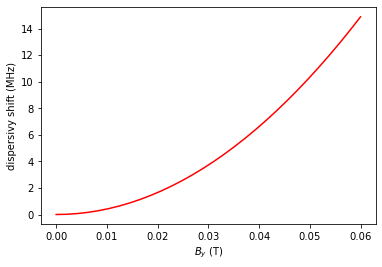

In [298]:
plt.plot(linspace(0.0, 0.06, 30), shift_ryd, 'r')
plt.ylabel('dispersivу shift (MHz)')
plt.xlabel('$B_y$ (T)')

In [299]:
B_y = linspace(0.0, 0.25, 100)
B_z = linspace(0.1, 0.25, 100)

chi_array = np.zeros((100, 100), dtype = float)

for i_ind, i_val in enumerate(B_y):
    for j_ind, j_val in enumerate(B_z):
        chi_array[i_ind][j_ind] = Dispersive_Landau(i_val, j_val, Electric_field)

<ipython-input-300-1c13784a8914>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p = axes.pcolor(B_z, B_y, 2*chi_array*10**3, cmap = cm.gist_rainbow_r)


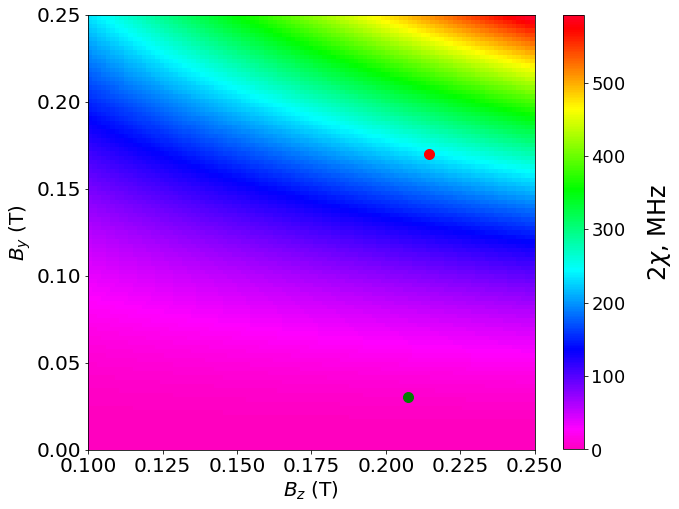

In [300]:
#hfont = {'fontname':'Tahoma'}
fig, axes = plt.subplots(1,1,figsize = (10, 8))
p = axes.pcolor(B_z, B_y, 2*chi_array*10**3, cmap = cm.gist_rainbow_r)
axes.tick_params(axis ='x', labelsize = 20)
axes.tick_params(axis ='y', labelsize = 20)
axes.set_xlabel(r'$B_z$ (T)', fontsize=20)
axes.set_ylabel(r'$B_y$ (T)', fontsize = 20)
#axes.set_xlim((1, time_steps))
cb = fig.colorbar(p, ax = axes)
cb.set_label(r'$2\chi$, MHz', labelpad = 20, rotation = 90, fontsize = 24)
cb.ax.tick_params(labelsize = 18)
#ymin, ymax = axes.get_ylim()
#axes.set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))
#xmin, xmax = axes.get_xlim()
#axes.set_xticks(np.round(np.linspace(xmin-1, xmax, 4), 2))

plt.plot(0.03575*6, 0.17, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
plt.plot(0.03575*5.8, 0.03, marker="o", markersize=10, markeredgecolor="green", markerfacecolor="green")

plt.gcf().set_size_inches(10,8)
plt.savefig("C:/Users/Kirill/Desktop/Chi_vs_fields_He4_zoom2.png", bbox_inches="tight")
#plt.savefig("C:/Users/Kirill/Desktop/Chi_vs_fields_He3.png", bbox_inches="tight")

# Correlation analysis

In [30]:
NN = 20

# cavity operators
a = tensor(destroy(NN), qeye(2))
nc = a.dag() * a
xc = a + a.dag()

# atomic operators
sm = tensor(qeye(NN), destroy(2))
sz = tensor(qeye(NN), sigmaz())
sx = tensor(qeye(NN), sigmax())
nq = sm.dag() * sm
xq = sm + sm.dag()

I = tensor(qeye(NN), qeye(2))

collapse operators

In [31]:
g1 = 0.002        # relaxation rate
g2 = 0.001        # dephasing rate
n_th = 0.1       # bath temperature

##----------------------------------------------------

c_ops = []
c_ops.append(np.sqrt(g1 * (1+n_th)) * sm)
c_ops.append(np.sqrt(g1 * n_th) * sm.trans().conj())
c_ops.append(np.sqrt(g2) * sz)

In [32]:
B_y = 0.5
B_z = 0.03572386754*12
chi = Dispersive_Landau(B_y, B_z, Electric_field)*2*np.pi
wr = qe/me * B_z / 10**9                                                          
wq = (eigenvalues_z[1]-eigenvalues_z[0]) * (Rydberg_Constant/h) * 2 * pi / 10**9      
print('Landau frequency:', wr/2/np.pi, 'GHz')
print('Rydberg frequency:', wq/2/np.pi, 'GHz')
delta = abs(wq - wr)
print('Detuning:', delta/2/np.pi, 'GHz')
g = np.sqrt(chi*delta)
print('Coupling constant:', g/2/np.pi, 'GHz')
print('Dispersive shift:', chi/2/np.pi*10**3, 'MHz')
Demo_rate = g**2/delta**2
print('Demolition rate:', Demo_rate*100, '%')
Crit_N = (delta/2/g)**2
print('Critical number of photons:', Crit_N)

Landau frequency: 12.000000003768204 GHz
Rydberg frequency: 118.66287725964892 GHz
Detuning: 106.66287725588072 GHz
Coupling constant: 10.326580391904315 GHz
Dispersive shift: 999.7692293134098 MHz
Demolition rate: 0.937316951346621 %
Critical number of photons: 26.671874400738297


Multiply all frequencies by the factor convenient for calculation

In [33]:
factor = wq/2/np.pi/3

wq = wq/factor
wr = wr/factor
chi = chi/factor
print('Normalized Rydberg frequency:', wq/2/np.pi, 'GHz')
print('Normalized Landau frequency:', wr/2/np.pi, 'GHz')
print('Normalized Dispersive shift:', chi/2/np.pi*10**3, 'MHz')

Normalized Rydberg frequency: 2.9999999999999996 GHz
Normalized Landau frequency: 0.3033804745230658 GHz
Normalized Dispersive shift: 25.275871925618123 MHz


In [34]:
factor

39.55429241988298

In [35]:
# dispersive hamiltonian
H = wr * (a.dag() * a + I/2.0) + (wq / 2.0) * sz + chi * (a.dag() * a + I/2) * sz

Try different initial state of the resonator, and see how the spectrum further down in the notebook reflects the photon distribution chosen here.

In [108]:
#psi0 = tensor(coherent(NN, sqrt(4)), (basis(2,0)+basis(2,1)).unit())
psi0 = tensor((coherent(NN, sqrt(4)) + coherent(NN, sqrt(0))), (basis(2,0)+basis(2,1)).unit())
#psi0 = tensor(coherent(NN, sqrt(2)), (basis(2,0)+basis(2,1)).unit())

In [109]:
psi0

Quantum object: dims = [[20, 2], [1, 1]], shape = (40, 1), type = ket
Qobj data =
[[8.02803278e-01]
 [8.02803278e-01]
 [1.91392993e-01]
 [1.91392993e-01]
 [2.70670566e-01]
 [2.70670566e-01]
 [3.12543449e-01]
 [3.12543449e-01]
 [3.12543449e-01]
 [3.12543449e-01]
 [2.79547359e-01]
 [2.79547359e-01]
 [2.28249463e-01]
 [2.28249463e-01]
 [1.72540376e-01]
 [1.72540376e-01]
 [1.22004470e-01]
 [1.22004470e-01]
 [8.13363134e-02]
 [8.13363134e-02]
 [5.14416004e-02]
 [5.14416004e-02]
 [3.10204561e-02]
 [3.10204561e-02]
 [1.79096534e-02]
 [1.79096534e-02]
 [9.93454447e-03]
 [9.93454447e-03]
 [5.31004475e-03]
 [5.31004475e-03]
 [2.74271105e-03]
 [2.74271105e-03]
 [1.36951636e-03]
 [1.36951636e-03]
 [6.69455130e-04]
 [6.69455130e-04]
 [3.02105194e-04]
 [3.02105194e-04]
 [1.71795013e-04]
 [1.71795013e-04]]

### Time evolution

In [110]:
tlist = np.linspace(0, 250, 1000)

In [111]:
res = mesolve(H, psi0, tlist, [], [], options=Odeoptions(nsteps=5000))

### Excitation numbers

We can see that the systems do not exchange any energy, because of they are off resonance with each other.

In [112]:
nc_list = expect(nc, res.states)
nq_list = expect(nq, res.states)

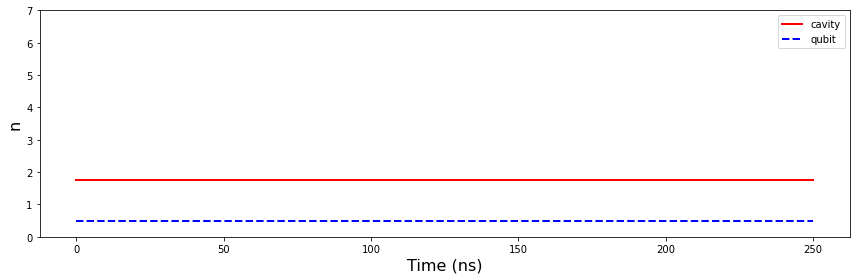

In [113]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,4))

ax.plot(tlist, nc_list, 'r', linewidth=2, label="cavity")
ax.plot(tlist, nq_list, 'b--', linewidth=2, label="qubit")
ax.set_ylim(0, 7)
ax.set_ylabel("n", fontsize=16)
ax.set_xlabel("Time (ns)", fontsize=16)
ax.legend()

fig.tight_layout()

## Resonator quadrature

However, the quadratures of the resonator are oscillating rapidly.


In [97]:
xc_list = expect(xc, res.states)

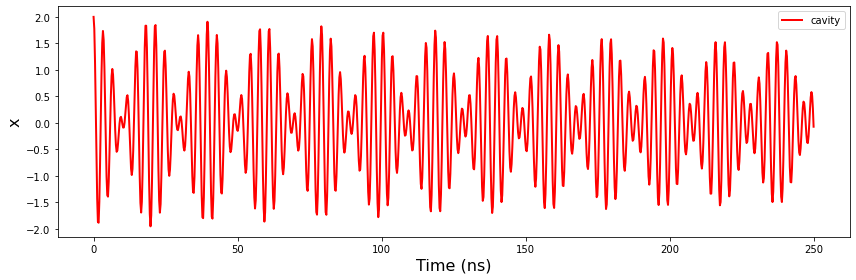

In [98]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,4))

ax.plot(tlist, xc_list, 'r', linewidth=2, label="cavity")
ax.set_ylabel("x", fontsize=16)
ax.set_xlabel("Time (ns)", fontsize=16)
ax.legend()

fig.tight_layout()

### Correlation function for the resonator

In [99]:
tlist = np.linspace(0, 2000, 20000)

Calculate the two-operator two-time correlation function:
$\left<A(t+\tau)B(t)\right>$
along two time axes using the quantum regression theorem and the
evolution solver indicated by the `solver` parameter.

In [100]:
corr_vec = correlation_2op_2t(H, psi0, None, tlist, [c_ops], a.dag(), a)   #, options=Odeoptions(nsteps=10000)

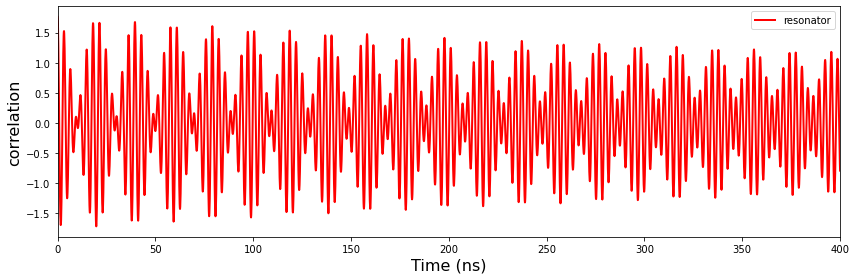

In [101]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,4))

ax.plot(tlist, real(corr_vec), 'r', linewidth=2, label="resonator")
ax.set_ylabel("correlation", fontsize=16)
ax.set_xlabel("Time (ns)", fontsize=16)
ax.legend()
ax.set_xlim(0,400)
fig.tight_layout()

### Spectrum of the resonator

In [79]:
w, S = spectrum_correlation_fft(tlist, corr_vec)

In [80]:
factor

39.55429241988298

(8.000923086514565, 15.999076921021846)

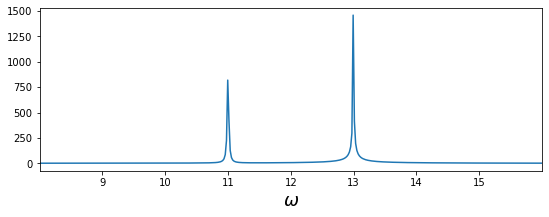

In [81]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot(w / (2 * pi) * factor, abs(S))
ax.set_xlabel(r'$\omega$', fontsize=18)
ax.set_xlim((wr-4*chi)/(2*pi)* factor, (wr+4*chi)/(2*pi)* factor)

Here we can see how the resonator peak is split and shiften up and down due to the superposition of 0 and 1 states of the qubit! We can also verify that the splitting is exactly $2\chi$, as expected:

(-2.0, 2.0)

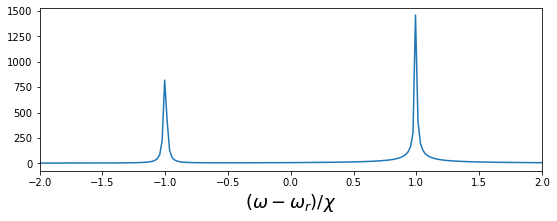

In [82]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot((w-wr)/chi, abs(S))
ax.set_xlabel(r'$(\omega-\omega_r)/\chi$', fontsize=18)
ax.set_xlim(-2,2)

### Correlation function of the qubit

In [83]:
corr_vec = correlation_2op_2t(H, psi0, None, tlist, [c_ops], sx, sx) #, options=Odeoptions(nsteps=1000)

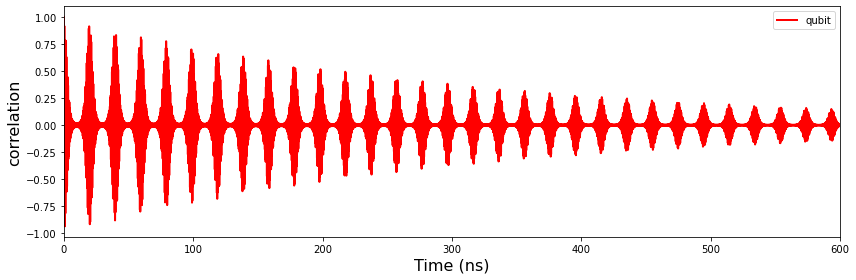

In [84]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,4))

ax.plot(tlist, real(corr_vec), 'r', linewidth=2, label="qubit")
ax.set_ylabel("correlation", fontsize=16)
ax.set_xlabel("Time (ns)", fontsize=16)
ax.legend()
ax.set_xlim(0,600)
fig.tight_layout()

### Spectrum of the qubit

The spectrum of the qubit has an interesting structure: from it one can see the photon distribution in the resonator mode!

In [85]:
w, S = spectrum_correlation_fft(tlist, corr_vec)

Text(0.5, 0, '$\\omega$')

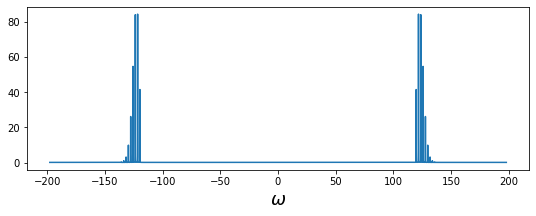

In [86]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot(w*factor/ (2 * np.pi) , abs(S))
ax.set_xlabel(r'$\omega$', fontsize=18)

It's a bit clearer if we shift the spectrum and scale it with $2\chi$

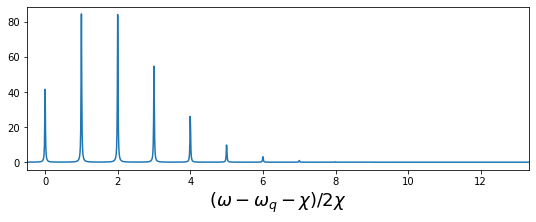

In [87]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot((w - wq - chi) / (2 * chi), abs(S))
ax.set_xlabel(r'$(\omega - \omega_q - \chi)/2\chi$', fontsize=18)
ax.set_xlim(-.5, NN/1.5);

Compare to the cavity fock state distribution:

In [88]:
rho_cavity = ptrace(res.states[-1], 0)

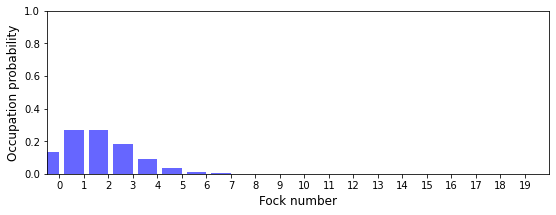

In [89]:
fig, axes = plt.subplots(1, 1, figsize=(9,3))

axes.bar(arange(0, NN)-.4, real(rho_cavity.diag()), color="blue", alpha=0.6)
axes.set_ylim(0, 1)
axes.set_xlim(-0.5, NN)
axes.set_xticks(arange(0, NN))
axes.set_xlabel('Fock number', fontsize=12)
axes.set_ylabel('Occupation probability', fontsize=12);

And if we look at the cavity wigner function we can see that after interacting dispersively with the qubit, the cavity is no longer in a coherent state, but in a superposition of coherent states.

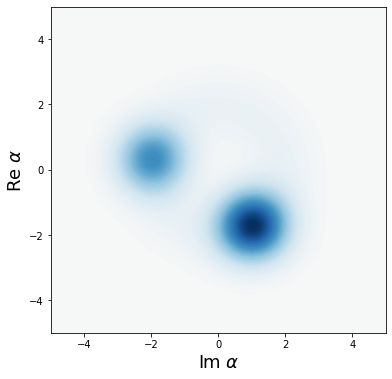

In [90]:
fig, axes = plt.subplots(1, 1, figsize=(6,6))

xvec = np.linspace(-5,5,200)
W = wigner(rho_cavity, xvec, xvec)
wlim = abs(W).max()

axes.contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-wlim,wlim), cmap=plt.get_cmap('RdBu'))
axes.set_xlabel(r'Im $\alpha$', fontsize=18)
axes.set_ylabel(r'Re $\alpha$', fontsize=18);

## Plotting

In [ ]:
Frequency_0 = 90                                                 #f_MV frequency [GHz]

In [ ]:
p12='figure_1/'                                                       #Folder for saving calculation data

Eigenvalues_full_stack = np.stack(Eigenvalues_full, axis = 1)
Eigenstates_full_stack = np.stack(Eigenstates_full, axis = 1)

pickle.dump (Eigenvalues_full_stack, open(p12 + "Eigenvalues_full_stack.p", "wb" ))
pickle.dump (Eigenstates_full_stack, open(p12 + "Eigenstates_full_stack.p", "wb" ))

Eigenvalues_nofield_stack = np.stack(Eigenvalues_nofield, axis = 1)
Eigenstates_nofield_stack = np.stack(Eigenstates_nofield, axis = 1)

pickle.dump (Eigenvalues_nofield_stack, open(p12 + "Eigenvalues_nofield_stack.p", "wb" ))
pickle.dump (Eigenstates_nofield_stack, open(p12 + "Eigenstates_nofield_stack.p", "wb" ))

In [ ]:
## subtract eigenvalues by the lowest one
Eigenvalues = Eigenvalues_full_stack - Eigenvalues_full_stack[:,0,None]
Frequencies = Eigenvalues * (Rydberg_Constant/h/1e9)

Eigenvalues_nofield = Eigenvalues_nofield_stack - Eigenvalues_nofield_stack[:,0,None]
Frequencies_nofield = Eigenvalues_nofield * (Rydberg_Constant/h/1e9)

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(16, 12))
for i in arange(10):
    #p = plt.scatter(B_z, Frequencies[i], s = 2, color = 'b', marker = 'o', norm = plt.Normalize(0,10))
    p = plt.plot(B_z, Frequencies_nofield[i]-Frequency_0, color = 'r', linewidth = 1)
    p = plt.plot(B_z, Frequencies[i]-Frequency_0,   color = '#4b0082', linewidth = 1)

#axes.set_ylim(-100, 100)
#axes.set_xlim(0.2, 3.5)
#axes.invert_yaxis()
axes.set_title(r'$E_{{\perp}}={}$ V/cm, $B_y ={:.2f}$ T'.format(Electric_field/100, B_y), fontsize = 'large')
axes.set_ylabel(r'$E$ (GHz)', fontsize = 'large')
axes.set_xlabel(r'$B_z$ (T)', fontsize = 'large')
plt.grid(True, 'major', linestyle = '--')

fig.savefig(p12 + "bz-vs-energy,By={:.2f},Ez={:.1f}.pdf".format(B_y, Electric_field), bbox_inches='tight')
fig.savefig(p12 + "bz-vs-energy,By={:.2f},Ez={:.1f}.png".format(B_y, Electric_field), bbox_inches='tight',dpi = 300)
plt.show()

In [9]:
Landau_radius(1,30)

35.047578650359256